<a href="https://colab.research.google.com/github/JuanZapa7a/semiotics/blob/main/QAT_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantization Aware Training (QAT) using Larq for binarized quantization with the CIFAR10 dataset





## 1. Installation of Larq and necessary dependencies

In [1]:
!pip -q install tensorflow==2.10.0
!pip -q install larq==0.13.1

import tensorflow as tf
import larq as lq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 22.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
google-cloud-aipla

## 2. Data preparation (CIFAR10)

Download and prepare the CIFAR10 dataset.
CIFAR-10 contains images of size $32 \times 32 \times 3$, includes 10 classes and already comes with 3 colour channels (RGB).

The code will display the dimensions of the images and labels:
- **Training images:** `(50000, 32, 32, 3)`
- **Training labels:** `(50000, 1)`
- **Test images:** `(10000, 32, 32, 3)`
- **Test labels:** `(10000, 1)`


In [2]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Check the original dimensions of CIFAR-10
# Should be (50000, 32, 32, 3) for train_images and (10000, 32, 32, 3) for test_images
print("Original dimensions:")
print("Train images:", train_images.shape)
print("Test images:", test_images.shape)

# Normalize the images to the range [-1, 1]
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

# Check dimensions after normalization
print("Dimensions after normalization:")
print("Train images:", train_images.shape, "Train labels:", train_labels.shape)
print("Test images:", test_images.shape, "Test labels:", test_labels.shape)



170498071/170498071 [==============================] - 3s 0us/step
Original dimensions:
Train images: (50000, 32, 32, 3)
Test images: (10000, 32, 32, 3)
Dimensions after normalization:
Train images: (50000, 32, 32, 3) Train labels: (50000, 1)
Test images: (10000, 32, 32, 3) Test labels: (10000, 1)


## 3. Creation of a base model.

To train the same model without binarization and quantization (i.e., using full precision for both weights and activations), we simply need to remove the QuantConv2D and QuantDense layers, replacing them with standard convolutional (Conv2D) and dense (Dense) layers from TensorFlow's Keras API.

In [3]:
import tensorflow as tf

# Define the standard (non-binarized) model architecture
model_normal = tf.keras.models.Sequential()

# First layer: Standard convolutional layer (no quantization)
model_normal.add(tf.keras.layers.Conv2D(
    32, (3, 3),                        # 32 filters of size 3x3
    activation="relu",                 # Use ReLU activation instead of binary
    use_bias=False,                    # No bias for simplicity
    input_shape=(32, 32, 3)            # Input shape for CIFAR-10
))
model_normal.add(tf.keras.layers.MaxPooling2D((2, 2)))    # Max pooling for downsampling
model_normal.add(tf.keras.layers.BatchNormalization(scale=False)) # Batch normalization

# Second standard convolutional layer
model_normal.add(tf.keras.layers.Conv2D(
    64, (3, 3),
    activation="relu",
    use_bias=False,
))
model_normal.add(tf.keras.layers.MaxPooling2D((2, 2)))     # Max pooling
model_normal.add(tf.keras.layers.BatchNormalization(scale=False))

# Third standard convolutional layer
model_normal.add(tf.keras.layers.Conv2D(
    64, (3, 3),
    activation="relu",
    use_bias=False,
))
model_normal.add(tf.keras.layers.BatchNormalization(scale=False))
model_normal.add(tf.keras.layers.Flatten())                # Flatten the output for the dense layers

# Fully connected (dense) layer with 64 units
model_normal.add(tf.keras.layers.Dense(64, activation="relu", use_bias=False))
model_normal.add(tf.keras.layers.BatchNormalization(scale=False))

# Output layer for classification (10 classes for CIFAR-10)
model_normal.add(tf.keras.layers.Dense(10, activation="softmax", use_bias=False))
model_normal.add(tf.keras.layers.BatchNormalization(scale=False))


In [4]:
model_normal.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        864       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 32)       96        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18432     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                        

## 4. Training and evaluation of the normal model

To train the same model without binarization and quantization (i.e., using full precision for both weights and activations), we simply need to remove the QuantConv2D and QuantDense layers, replacing them with standard convolutional (Conv2D) and dense (Dense) layers from TensorFlow's Keras API.

In [6]:
# Compile the model for normal training
model_normal.compile(
    optimizer='adam',                       # Adam optimizer
    loss="sparse_categorical_crossentropy", # Cross-entropy loss for classification
    metrics=["accuracy"]                    # Accuracy as the evaluation metric
)

# Train the model
history_normal = model_normal.fit(
    train_images, train_labels,
    epochs=50,                        # Number of epochs
    batch_size=64,                    # Batch size
    validation_data=(test_images, test_labels)  # Use test data for validation
)

# Evaluate the model on the test dataset
test_loss_normal, test_accuracy_normal = model_normal.evaluate(test_images, test_labels)

print(f"Test Accuracy (Normal): {test_accuracy_normal * 100:.2f}%")
print(f"Test Loss(Normal): {test_loss_normal:.4f}")

Epoch 1/50
782/782 [==============================] - 87s 109ms/step - loss: 8.0414 - accuracy: 0.2043 - val_loss: 6.2237 - val_accuracy: 0.2273
Epoch 2/50
782/782 [==============================] - 81s 103ms/step - loss: 5.3696 - accuracy: 0.2382 - val_loss: 5.0458 - val_accuracy: 0.2269
Epoch 3/50
782/782 [==============================] - 87s 111ms/step - loss: 4.1074 - accuracy: 0.2406 - val_loss: 3.3837 - val_accuracy: 0.2497
Epoch 4/50
782/782 [==============================] - 83s 106ms/step - loss: 4.4716 - accuracy: 0.2230 - val_loss: 4.2817 - val_accuracy: 0.2403
Epoch 5/50
782/782 [==============================] - 82s 105ms/step - loss: 3.7575 - accuracy: 0.2314 - val_loss: 8.9830 - val_accuracy: 0.1461
Epoch 6/50
782/782 [==============================] - 83s 106ms/step - loss: 4.7780 - accuracy: 0.1559 - val_loss: 4.2603 - val_accuracy: 0.1640
Epoch 7/50
782/782 [==============================] - 84s 107ms/step - loss: 4.0454 - accuracy: 0.1605 - val_loss: 3.9177 - val_ac

## 5. Creation of a binarized model



In [19]:
import larq as lq
import tensorflow as tf

# Define default quantization options for all layers except the first layer
kwargs = dict(
    input_quantizer="ste_sign",      # Quantizes activations using Sign-STE (binary quantization to -1 or +1)
    kernel_quantizer="ste_sign",     # Quantizes weights to binary values (-1 or +1) with Sign-STE
    kernel_constraint="weight_clip"  # Clips weights within a set range (typically -1 to +1) to stabilize training
)

# Initialize a Sequential model
model = tf.keras.models.Sequential()

# First layer: Quantized convolutional layer (only quantizing weights, not inputs)
model.add(lq.layers.QuantConv2D(
    32, (3, 3),                      # 32 filters of size 3x3
    kernel_quantizer="ste_sign",     # Quantize weights to -1 or +1
    kernel_constraint="weight_clip", # Restrict weights to a range for stability
    use_bias=False,                  # Disable bias for simplicity
    input_shape=(32, 32, 3)          # Input shape for CIFAR-10 (32x32 RGB images)
))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))         # Downsample with max pooling
model.add(tf.keras.layers.BatchNormalization(scale=False)) # Batch normalization to stabilize activations

# Second quantized convolutional layer (quantizes both weights and activations)
model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))         # Downsample again
model.add(tf.keras.layers.BatchNormalization(scale=False))

# Third quantized convolutional layer (also quantizes both weights and activations)
model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())                    # Flatten the output for fully connected layers

# Quantized dense (fully connected) layer with 64 units
model.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))

# Final quantized dense layer for output (10 classes for CIFAR-10)
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))        # Softmax activation for classification probabilities


In [8]:
lq.models.summary(model)

+sequential_1 stats----------------------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs  32-bit MACs |
|                              (bit)                        x 1       x 1    (kB)                          |
+----------------------------------------------------------------------------------------------------------+
| quant_conv2d                     -  (-1, 30, 30, 32)      864         0    0.11           0       777600 |
| max_pooling2d_2                  -  (-1, 15, 15, 32)        0         0       0           0            0 |
| batch_normalization_5            -  (-1, 15, 15, 32)        0        64    0.25           0            0 |
| quant_conv2d_1                   1  (-1, 13, 13, 64)    18432         0    2.25     3115008            0 |
| max_pooling2d_3                  -    (-1, 6, 6, 64)        0         0       0           0            0 |
| batch_normalizati

## 6. Training and evaluation of the binarized model with QAT



In [9]:
# Compile the model with an optimizer and loss function
model.compile(
    optimizer='adam',                      # Adam optimizer is often effective for training binarized networks
    loss="sparse_categorical_crossentropy",# Cross-entropy loss for classification
    metrics=["accuracy"]                   # Accuracy as the evaluation metric
)

# Train the model where QAT takes place as the model learns to optimize quantized weights and activations.
history = model.fit(
    train_images, train_labels,
    epochs=50,                           # Number of training epochs
    batch_size=64,                      # Batch size for training
    validation_data=(test_images, test_labels) # Evaluate on test set after each epoch
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/50
782/782 [==============================] - 92s 115ms/step - loss: 1.7331 - accuracy: 0.3877 - val_loss: 1.5767 - val_accuracy: 0.4543
Epoch 2/50
782/782 [==============================] - 89s 114ms/step - loss: 1.5049 - accuracy: 0.4975 - val_loss: 1.4432 - val_accuracy: 0.5237
Epoch 3/50
782/782 [==============================] - 88s 113ms/step - loss: 1.4171 - accuracy: 0.5378 - val_loss: 1.4064 - val_accuracy: 0.5353
Epoch 4/50
782/782 [==============================] - 93s 118ms/step - loss: 1.3661 - accuracy: 0.5593 - val_loss: 1.3566 - val_accuracy: 0.5578
Epoch 5/50
782/782 [==============================] - 88s 112ms/step - loss: 1.3337 - accuracy: 0.5718 - val_loss: 1.3087 - val_accuracy: 0.5783
Epoch 6/50
782/782 [==============================] - 93s 119ms/step - loss: 1.2973 - accuracy: 0.5880 - val_loss: 1.3123 - val_accuracy: 0.5788
Epoch 7/50
782/782 [==============================] - 91s 116ms/step - loss: 1.2779 - accuracy: 0.5957 - val_loss: 1.2894 - val_ac

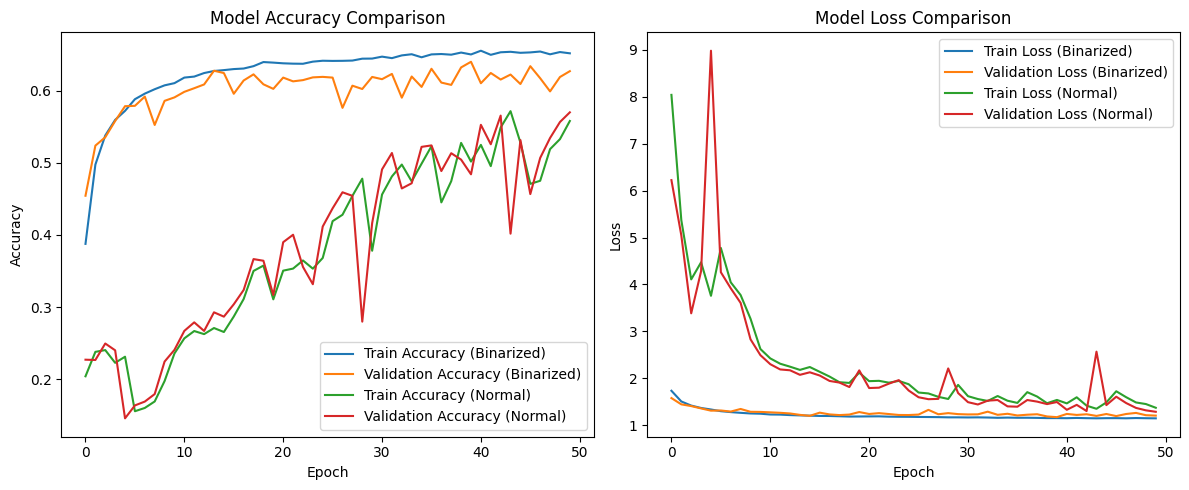

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values for both models
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy (Binarized)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Binarized)')
plt.plot(history_normal.history['accuracy'], label='Train Accuracy (Normal)')
plt.plot(history_normal.history['val_accuracy'], label='Validation Accuracy (Normal)')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (Binarized)')
plt.plot(history.history['val_loss'], label='Validation Loss (Binarized)')
plt.plot(history_normal.history['loss'], label='Train Loss (Normal)')
plt.plot(history_normal.history['val_loss'], label='Validation Loss (Normal)')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## 7. Compare models

###**A. SIZE**

We can evaluate how much memory each model takes up, specifically looking at the number of parameters (weights) in each model. The size of the model can be directly related to the total number of parameters, since each parameter is a floating-point value and requires memory for storage.

In [11]:
# Print summary of both models to compare parameters
print("\nBinarized Model Summary:")
model.summary()

print("Normal Model Summary:")
model_normal.summary()


Binarized Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_conv2d (QuantConv2D)  (None, 30, 30, 32)        864       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 15, 15, 32)       96        
 hNormalization)                                                 
                                                                 
 quant_conv2d_1 (QuantConv2D  (None, 13, 13, 64)       18432     
 )                                                               
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                        

In [12]:

# Calculate the model size in bytes
def calculate_model_size(model, is_binarized=False):
    total_params = model.count_params()

    if is_binarized:
        # Binarized model parameters are stored in 1 byte per parameter
        return total_params  # 1 byte per parameter for binarized model
    else:
        # Normal model parameters are stored in 4 bytes per parameter (32-bit floating point)
        return total_params * 4  # 4 bytes per parameter for normal model

# Get the sizes of both models
normal_model_size = calculate_model_size(model_normal, is_binarized=False)
binarized_model_size = calculate_model_size(model, is_binarized=True)

# Print the model sizes in MB
print(f"Normal Model Size: {normal_model_size / (1024**2):.2f} MB")
print(f"Binarized Model Size: {binarized_model_size / (1024**2):.2f} MB")


Normal Model Size: 0.47 MB
Binarized Model Size: 0.12 MB


In [13]:
# Save both models to disk
model.save("binarized_model.h5")
model_normal.save("normal_model.h5")

# Compare file sizes
import os

binarized_model_size = os.path.getsize("binarized_model.h5") / (1024**2)
normal_model_size = os.path.getsize("normal_model.h5") / (1024**2)  # Size in MB


print(f"Normal Model File Size: {normal_model_size:.2f} MB")
print(f"Binarized Model File Size: {binarized_model_size:.2f} MB")

Normal Model File Size: 1.48 MB
Binarized Model File Size: 1.48 MB


In [14]:
import time

# Function to measure inference time
def measure_inference_time(model, test_images):
    start_time = time.time()
    predictions = model.predict(test_images)
    end_time = time.time()

    inference_time = end_time - start_time  # Time taken in seconds
    return inference_time

# Choose a batch of 100 test samples for inference time
batch_size = 100
test_batch = test_images[:batch_size]

# Measure inference time for both models
inference_time_normal = measure_inference_time(model_normal, test_batch)
inference_time_binarized = measure_inference_time(model, test_batch)

print(f"Inference Time (Normal Model): {inference_time_normal:.4f} seconds")
print(f"Inference Time (Binarized Model): {inference_time_binarized:.4f} seconds")

4/4 [==============================] - 0s 12ms/step
Inference Time (Normal Model): 0.4866 seconds
Inference Time (Binarized Model): 0.4545 seconds


In [15]:
# Function to measure throughput (images per second)
def measure_throughput(model, test_images, batch_size=10000):
    start_time = time.time()
    model.predict(test_images[:batch_size])  # Make prediction on a batch
    end_time = time.time()

    time_taken = end_time - start_time
    throughput = batch_size / time_taken  # Images per second
    return throughput

# Measure throughput for both models
throughput_normal = measure_throughput(model_normal, test_images, batch_size)
throughput_binarized = measure_throughput(model, test_images, batch_size)

print(f"Throughput (Normal Model): {throughput_normal:.2f} images per second")
print(f"Throughput (Binarized Model): {throughput_binarized:.2f} images per second")

4/4 [==============================] - 0s 12ms/step
Throughput (Normal Model): 510.19 images per second
Throughput (Binarized Model): 797.08 images per second


In [16]:
# Evaluate the accuracy of both models
test_loss_normal, test_accuracy_normal = model_normal.evaluate(test_images, test_labels)
test_loss_binarized, test_accuracy_binarized = model.evaluate(test_images, test_labels)

print(f"Test Accuracy (Normal Model): {test_accuracy_normal * 100:.2f}%")
print(f"Test Accuracy (Binarized Model): {test_accuracy_binarized * 100:.2f}%")

313/313 [==============================] - 5s 17ms/step - loss: 1.2034 - accuracy: 0.6268
Test Accuracy (Normal Model): 56.98%
Test Accuracy (Binarized Model): 62.68%


In [17]:
import psutil
import os

# Function to get current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)  # Memory in MB

# Measure memory usage during inference for both models
memory_usage_normal_start = get_memory_usage()
model_normal.predict(test_batch)  # Inference on the normal model
memory_usage_normal_end = get_memory_usage()

memory_usage_binarized_start = get_memory_usage()
model.predict(test_batch)  # Inference on the binarized model
memory_usage_binarized_end = get_memory_usage()

print(f"Memory Usage (Normal Model): {memory_usage_normal_end - memory_usage_normal_start:.2f} MB")
print(f"Memory Usage (Binarized Model): {memory_usage_binarized_end - memory_usage_binarized_start:.2f} MB")

4/4 [==============================] - 0s 13ms/step
Memory Usage (Normal Model): 2.36 MB
Memory Usage (Binarized Model): -232.03 MB


In [18]:
import psutil
import os

# Function to get current memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)  # Memory in MB

# Measure memory usage during inference for both models
memory_usage_normal_start = get_memory_usage()
model_normal.predict(test_batch)  # Inference on the normal model
memory_usage_normal_end = get_memory_usage()

memory_usage_binarized_start = get_memory_usage()
model.predict(test_batch)  # Inference on the binarized model
memory_usage_binarized_end = get_memory_usage()

print(f"Memory Usage (Normal Model): {memory_usage_normal_end - memory_usage_normal_start:.2f} MB")
print(f"Memory Usage (Binarized Model): {memory_usage_binarized_end - memory_usage_binarized_start:.2f} MB")

4/4 [==============================] - 0s 16ms/step
Memory Usage (Normal Model): 0.00 MB
Memory Usage (Binarized Model): 0.00 MB
